---
format:
  html:
    code-fold: true
    fig-align: center
---

## Hertz contact with the Penalty Method


In this notebook, we will solve a Hertz contact problem with the penalty method. We will use the penalty method to enforce the contact constraint.


In [221]:
#| code-fold: true
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

import femsolver
from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import gmsh
import numpy as np
import meshio

import equinox as eqx
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

In [236]:
#| code-fold: true
#| output: false

def generate_half_circle_mesh(radius: float = 1.0, eps: float = 1e-3):

    # Parameters
    R = radius  # Radius of the half-circle

    lc_fine   = 0.05   # Mesh characteristic length
    lc_coarse = 0.05   # Mesh characteristic length

    gmsh.initialize()
    gmsh.model.add("half_circle")

    # Create points
    p1 = gmsh.model.geo.addPoint( 0, R+eps, 0, lc_coarse)    # Center
    p2 = gmsh.model.geo.addPoint(-R, R+eps, 0, lc_coarse)    # Left point
    p3 = gmsh.model.geo.addPoint( R, R+eps, 0, lc_coarse)    # Right point

    # Create the arc (half-circle)
    p_mid = gmsh.model.geo.addPoint(0, R, 0, lc_fine)    # Midpoint at the bottom
    arc = gmsh.model.geo.addCircleArc(p2, p1, p3)

    # Create the flat line to close the half-circle
    line = gmsh.model.geo.addLine(p3, p2)

    # Create a line loop and surface
    loop = gmsh.model.geo.addCurveLoop([arc, line])
    surface = gmsh.model.geo.addPlaneSurface([loop])

    # Synchronize and mesh
    gmsh.model.geo.synchronize()

    # Create a Distance field to control mesh size near p_mid
    field_id = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(field_id, "NodesList", [p_mid])

    # Create a Threshold field to refine near p_mid and coarsen further away
    threshold_id = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_id, "InField", field_id)
    gmsh.model.mesh.field.setNumber(threshold_id, "SizeMin", lc_fine)      # finest
    gmsh.model.mesh.field.setNumber(threshold_id, "SizeMax", lc_coarse)    # coarsest
    gmsh.model.mesh.field.setNumber(threshold_id, "DistMin", 0.260)     # radius of fine mesh
    gmsh.model.mesh.field.setNumber(threshold_id, "DistMax", 0.541)     # start coarsening

    # Set it as background mesh size field
    gmsh.model.mesh.field.setAsBackgroundMesh(threshold_id)

    # Physical group for the surface
    gmsh.model.addPhysicalGroup(2, [surface], tag=1)
    gmsh.model.setPhysicalName(2, 1, "Half-Circle Surface")

    # Physical group for the arc boundary
    gmsh.model.addPhysicalGroup(1, [arc], tag=2)
    gmsh.model.setPhysicalName(1, 2, "Half-Circle Arc")

    # Physical group for the flat boundary
    gmsh.model.addPhysicalGroup(1, [line], tag=3)
    gmsh.model.setPhysicalName(1, 3, "Flat Boundary")

    # Set recombination to produce quad elements
    #gmsh.model.mesh.setRecombine(2, surface)
    # Set the recombination algorithm to Blossom (algorithm 8) for better quad meshing
    #gmsh.option.setNumber("Mesh.RecombineAll", 1)
    #gmsh.option.setNumber("Mesh.Algorithm", 8)

    # Generate the mesh
    gmsh.model.mesh.generate(2)
    mesh_file = "half_circle.msh"
    gmsh.write(mesh_file)
    gmsh.finalize()

    _mesh = meshio.read("half_circle.msh")

    contact_nodes = _mesh.cell_sets_dict["Half-Circle Arc"]["line"]

    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh, contact_nodes

In [237]:
#| code-fold: true
#| output: false

radius = 1.0
eps = 1e-3

mesh, contact_nodes = generate_half_circle_mesh(radius=radius, eps=eps)
n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 60%] Meshing curve 2 (Line)
Info    : Done meshing 1D (Wall 0.000547329s, CPU 0.001055s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0394178s, CPU 0.040208s)
Info    : 791 nodes 1580 elements
Info    : Writing 'half_circle.msh'...
Info    : Done writing 'half_circle.msh'



In [238]:
np.allclose(np.linalg.norm(mesh.coords[contact_nodes] - np.array([0, radius+eps]), axis=1), radius)

True

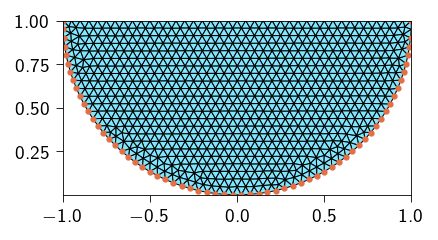

In [239]:
# | code-fold: true
# | fig-align: center

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.5,
    cmap=cmc.managua_r,
)
ax.scatter(mesh.coords[contact_nodes, 0], mesh.coords[contact_nodes, 1], color=colors.red, s=4)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

In [240]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=1.0, lmbda=1.0)

## Constitutive Model for Linear Elasticity

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.


In [241]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))

@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{contact}(u)$$

The contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\int_{\Gamma_c}\langle -g(u)\rangle^2 dA$$

For this example, we define the discrete penalization only at the nodes on the contact surface.
Therefore, the contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\sum_{i=1}^{N_c}\langle -g(u_i)\rangle^2 A_{i}$$

where $N_c$ is the number of nodes on the contact surface, $A_i$ is the area of the node $i$, and $g(u_i)$ is the gap function at node $i$.

The gap function is defined as:

$$g(u_i)=x_i+u_i-0.0$$


Below, we define the functions to compute the contact energy and the total energy.

In [ ]:
def maclauy_brackect(x):
    return jnp.where(x > 0, 0, x)

def compute_contact_energy(u: Array, coords: Array, contact_nodes: Array) -> Array:
    """Compute the contact energy for a given displacement field.
    Args:
        u: Displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e5
    node_area_weight = 1.0  # TODO: add the correct area of the node

    # Loop over nodes on the potential contact surface
    @vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[1] + u_node[1]) - 0.0
        penetration = maclauy_brackect(gap)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


@jax.jit
def _total_energy(
    u_flat: Array,
    coords: Array,
    contact_nodes: Array,
) -> Array:
    """Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    contact_energy = compute_contact_energy(u, coords, contact_nodes)
    strain_energy = total_strain_energy(u)
    return contact_energy + strain_energy


total_energy = eqx.Partial(_total_energy, coords=mesh.coords, contact_nodes=contact_nodes)

In [243]:
gradient = jax.grad(total_energy)
hessian = jax.jacfwd(gradient)

## Applying Dirichlet boundary conditions

In [250]:
y_max = np.max(mesh.coords[:, 1])

top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
fixed_dofs = jnp.concatenate([2 * top_nodes, 2 * top_nodes + 1])
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

u_target = jnp.zeros(n_dofs)
u_target = u_target.at[2 * top_nodes].set(0.0)
u_target = u_target.at[2 * top_nodes + 1].set(-0.2)
u_target_flat = u_target.flatten()

## Solving the problem

We will use the Newton's method to solve the problem.


In [251]:
#| code-fold: true

def newton_solver(
    u_target_flat,
    n_steps=10,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps
    u = jnp.zeros(n_dofs)

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])
        for i in range(max_iter):
            res = -gradient(u)
            H = hessian(u)
            res_r = res[free_dofs]

            H_rr = H[jnp.ix_(free_dofs, free_dofs)]

            delta_u = jnp.linalg.solve(H_rr, res_r)
            u = u.at[free_dofs].add(delta_u)

            norm_res = jnp.linalg.norm(res_r)
            print(f"  Residual: {norm_res:.2e}")
            if norm_res < tol:
                print(f"  Converged in {i+1} iterations with residual {norm_res:.2e}")
                break
        else:
            print("  Did not converge!")
    return u.reshape(-1, n_dofs_per_node)

In [252]:
#| output: false
u_solution = newton_solver(u_target_flat, n_steps=5)

Step 1/5
  Residual: 8.72e-01
  Residual: 9.54e+03
  Residual: 2.39e-02
  Residual: 9.64e-03
  Residual: 1.22e-13
  Converged in 5 iterations with residual 1.22e-13
Step 2/5
  Residual: 8.72e-01
  Residual: 1.27e+03
  Residual: 3.91e-13
  Converged in 3 iterations with residual 3.91e-13
Step 3/5
  Residual: 8.72e-01
  Residual: 7.67e+02
  Residual: 5.19e-03
  Residual: 4.15e-13
  Converged in 4 iterations with residual 4.15e-13
Step 4/5
  Residual: 8.72e-01
  Residual: 1.56e+03
  Residual: 9.44e-13
  Converged in 3 iterations with residual 9.44e-13
Step 5/5
  Residual: 8.72e-01
  Residual: 4.73e+02
  Residual: 1.06e-12
  Converged in 3 iterations with residual 1.06e-12


## Postprocessing

Let's plot the stress and the deformed configuration. We plot the $\sigma_{yy}$ stress.


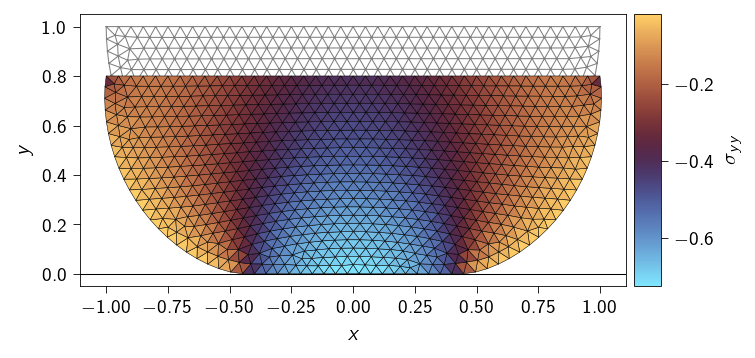

In [253]:
#| code-fold: true

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_element_values(u, mesh, values, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()

    ax.triplot(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        color="gray",
        linewidth=0.5,
    )

    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax, label=r"$\sigma_{yy}$")
    plt.show()


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
plot_element_values(u_solution, mesh, stresses[:, 1, 1].flatten())